# IR experimental code

In [1]:
import math
import os
from typing import List, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from theia.utils import display, read_positions

In [2]:
def approxContour(contour, options):
    """
    fit contour to a simpler shape
    accuracy is based on EPSILON_MULTIPLY
    """
    epsilon = options['epsilon'] * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

In [3]:
def calc_distance(p1, p2):
    """ return the distance between two points """
    return math.sqrt(((p2[0] - p1[0])**2) + ((p2[1] - p1[1])**2))


def get_contour_lengths(approx: List[List[List[int]]]) -> List[int]:
    """ 
    extract lengths from the co-ordinates 
    """
    # unnest and arrange into each corner co-ords
    # this could be done programmatically but not really worth it
    verticies = [
            [approx[0][0], approx[1][0]],
            [approx[1][0], approx[2][0]],
            [approx[2][0], approx[3][0]],
            [approx[3][0], approx[0][0]]
        ]
    lengths = list(map(lambda x: calc_distance(x[0], x[1]), verticies))
    return sorted(lengths)


def is_square(lengths, options) -> bool:
    """ check if the longest side is close in length to the shortest side """
    a = ((lengths[3] - lengths[0]) / lengths[3]) < options["square_ar"]
    b = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    c = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    return a & b & c

In [32]:
def filterContours(contours, options):
    """ 
    return only the contours that are squares
    """
    squareIndexes = []

    # filter contours
    for i, contour in enumerate(contours):  # for each of the found contours
        if cv2.contourArea(contour) > options["min_area"]:
            approx = approxContour(contour, options)
            if len(approx) in options["sides"]:
                area = cv2.contourArea(approx)
                hull = cv2.convexHull(approx)
                hull_area = cv2.contourArea(hull)
                solidity = float(area)/hull_area
                if solidity > options["min_solidity"]:
                    squareIndexes.append(i)
                #if is_square(get_contour_lengths(approx), options):
    
    return squareIndexes

In [5]:
def target_centre(contour: list) -> Tuple[int, int]:
    """ 
    given the square corners, return the centre of the square 
    """
    x = sum([item[0] for item in contour])/4
    y = sum([item[1] for item in contour])/4
    return int(x), int(y)

In [27]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def find_targets(image: np.ndarray, options) -> List[List[Tuple[int,int]]]:
    """ 
    return the centre position within the image
    """
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cl1 = clahe.apply(imgGray)
    imgBlurred = cv2.GaussianBlur(imgGray, (options["ksize"], options["ksize"]), options["sigma"])
    img_thresh = cv2.adaptiveThreshold(
        imgBlurred,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY,
        options["block_size"],
        options["c"]
    )

    #img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, options["kernel"])
    
    if options["debug"]: 
        display(img_thresh)

    contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    squareIndexes = filterContours(contours, options)
    
    if options["debug"]:
        imgCopy = image
        # for cont in contours:
        #     cv2.drawContours(imgCopy, cont, -1, (0, 255, 0), 3)
        # display(imgCopy)
        img2 = image
        for index in squareIndexes:
            cv2.drawContours(img2, contours[index], -1, (0, 255, 0), 3)
        display(img2)

    # this for loop is mainly to check if there are multiple squares in the same image
    # otherwise there would not be a loop
    
    results = []
    for index in squareIndexes:
        target_contour = approxContour(contours[index], options)

        reshaped = target_contour.reshape(4,2)

        centre = target_centre(reshaped)

        results.append(
            centre
        )


    if len(results) == 0:
        pass

    return results

# sim_dataset testing

In [7]:
def centre_check(predicted, actual, tol=20) -> bool:
    """ True if the centre is as expected else False """
    x = math.isclose(predicted[0], actual[0], abs_tol=tol)
    y = math.isclose(predicted[1], actual[1], abs_tol=tol)
    return x & y

In [8]:
ref = read_positions("./dataset/target_positions")

In [25]:
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 10000,
    "sides":[4],
    "debug":True,
    "kernel": np.ones((30,30),np.uint8)
}

predicted = find_targets(image, options)
print(predicted)
actual = ref[files[image_number]]
print(centre_check(predicted[0], actual))
print(len(predicted) == 1)

IMG_160729_071816_0092_RGB.JPG
[(977, 635)]
False
True


In [30]:
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/sim_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]
            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except:
        #result = find_targets(image, options, debug=True)
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 89.02 %
false positives 1.15 %
no. images: 173


# Understanding parameter effects

In [ ]:
results = []
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])

for block_size in range(29, 249, 20):
    print(block_size)
    for c in range(-100, 20, 20):
        for ksize in range(1, 9, 2):
            for sigma in [0]: #range(0, 10, 2):
                options = {
                    "block_size": block_size,
                    "c": c,
                    "ksize": ksize,
                    "sigma": sigma
                }
                result = find_targets(image, options, debug=False)
                try:
                    result[0]
                    if result[0][0] > 1080 and result[0][0] < 1100:
                        ans = 1
                    else:
                        ans = 0
                except:
                    ans = 0
                
                results.append((block_size, c, ksize, sigma, ans))

In [ ]:
df = pd.DataFrame(results)

,0,1,2,3,4
0,29,-100,1,0,0
1,29,-100,3,0,0
2,29,-100,5,0,0
3,29,-100,7,0,0
4,29,-80,1,0,0
...,...,...,...,...,...
331,289,-20,7,0,0
332,289,0,1,0,0
333,289,0,3,0,0
334,289,0,5,0,0


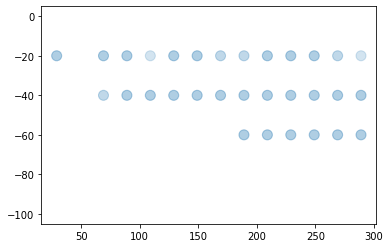

In [ ]:
plt.scatter(df[0], df[1], s=df[4]*100, alpha=0.1)

In [ ]:
df = df[df[4] == 1]

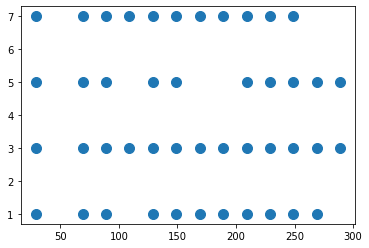

In [ ]:
df2 = df[df[1] == -20]
plt.scatter(df2[0], df2[2], s=100, alpha=1)

# Testing main IR functions

In [1]:
from theia import main
from theia import spec
import cv2
import os
from importlib import reload
reload(main)

loc = spec.LocationInfo()
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])
base_dir = os.getcwd()

IMG_160729_071816_0092_RGB.JPG


In [2]:
ir = main.ImageRecognition(base_dir)
ir.image_recognition(image, loc)

2022-01-26 14:54:42,172, [INFO], main , processing image
2022-01-26 14:54:42,492, [INFO], main , ImageRecognitionResult(image_name='c:\\Users\\olive\\Documents\\GitHub\\uas-theia\\runtime\\26012022_14-54-42.240916.jpg', centre=(2310, 3193), position=(0.0, 0.0))


# Experimenting with perspective

In [18]:
ref = read_positions("./dataset/target_positions_transformed")

result = 0
files = [f for f in os.listdir('./dataset/transform_dataset/')]
for image_number in [99]: #range(len(files)):
    image = cv2.imread('./dataset/transform_dataset/' + files[image_number])
    print(files[image_number])

    options = {
        "block_size": 249,
        "c": -39,
        "ksize": 49,
        "sigma": 0,
        "epsilon": 0.02,
        "square_ar": 0.4,
        "min_area": 3000,
    }

    predicted = find_targets(image, options, debug=True)
    if len(predicted) >= 0:
        result+=1
    print(predicted)

print(result/len(files))
print(centre_check(predicted[0], (1316, 2532)))

900-900.jpg
[(1318, 2534), (3707, 288)]
0.01
True


In [33]:
options = {
    "block_size": 249,
    "c": -39,
    "ksize": 49,
    "sigma": 0,
    "epsilon": 0.02,
    "square_ar": 0.4,
    "min_area": 3000,
}
ref = read_positions("./dataset/target_positions_transformed", offset=0)
files = [f for f in os.listdir('./dataset/transform_dataset/')]
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/transform_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]

            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except Exception as e:
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 80.35 %
false positives 13.55 %
no. images: 1557


# other

In [9]:
from theia import position_estimation
from theia.spec import LocationInfo
from theia.image_segmentation import find_targets
from theia.utils import display
import cv2
import os
import math
import geopy.distance
from datetime import datetime


target_location = (51.292308, -0.484431)
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\03_04_22\square"
files = [f for f in os.listdir(directory)]

start_height = 32

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False,
    "min_solidity":0.6
}

error_x = []
error_y = []
image_pitch = []
image_roll = []
image_height = []
image_heading = []
image_time = []
total_error=[]
dist_error = []
locations = []

all_data = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    #dst = cv2.undistort(image,cam,distCoeff)
    #display(dst)
    predicted = find_targets(image, options)
    name = file.split(",")
    try:
        l = LocationInfo(lat=float(name[2]), lon=float(name[1]), alt=float(name[0])-start_height,heading=float(name[3]), pitch=float(name[4]), roll=float(name[5]))
        predicted_location = position_estimation.triangulate(predicted[0], l)

        img_time = datetime.utcfromtimestamp(float(name[6].split(".jpg")[0]))
        err = math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2)
        dist_err = geopy.distance.distance(target_location, predicted_location).m
        if dist_err > 200:
            pass
        # elif img_time.minute < 15:
        #     pass
        else:
            image_pitch.append(l.pitch)
            image_roll.append(l.roll)
            image_height.append(l.alt)
            image_heading.append(l.heading)
            image_time.append(img_time)
            error_x.append(predicted_location[0]-target_location[0])
            error_y.append(predicted_location[1]-target_location[1])
            dist_error.append(dist_err)
            locations.append(predicted_location)
            all_data.append([predicted, l])
            
            total_error.append(math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2))
            print(dist_err)

    except Exception as e:
        print(e)


38.81033781455407
list index out of range
50.60600362792684
69.78172471091139
60.15862861024731
43.10472769497254
59.86223123059024
68.05162248088607
46.59470898606215
173.53309046811327
49.10202060002612
130.82151182065002
25.806961713474855
84.55948729957522
196.48734908852967
139.8766846307611
63.81908769273903
35.99589292683297
34.285522745344466
56.884379289356566
139.78664224848515
110.24400003366178
194.4718597106829
135.31461135157033
62.39631221824973
60.707551597612394
45.65164378526579
85.49301288770272
149.9409983027894
50.320493513764035
107.2437602434978
25.974865085293622
27.198563017823545
86.03571311629045
71.13152052194398
89.75517732545761
149.6962456617623
113.23437625104066
13.581224653621367
37.20075730062532
111.71916940689553
6.381509529897011
66.7131175654782
179.93074398020806
19.42278919261504
8.516203860650078
25.583098935435522
37.176235237622535
46.28558656454694


In [4]:
import numpy as np
print(np.average(dist_error))

76.77603659441758


-0.00010863261424010062
0.00012637791909687196


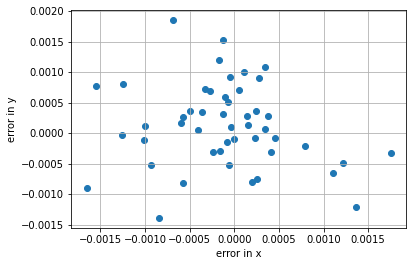

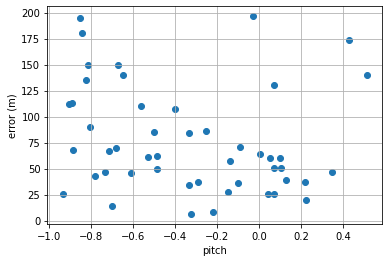

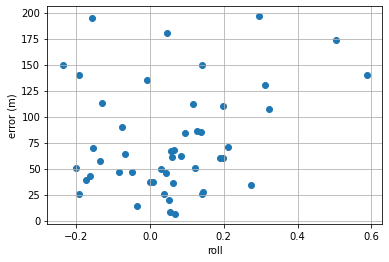

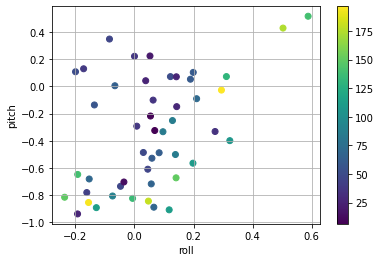

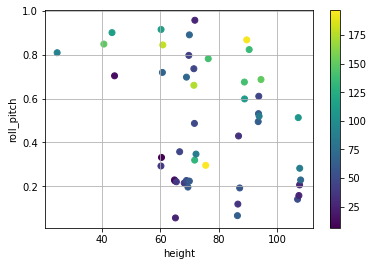

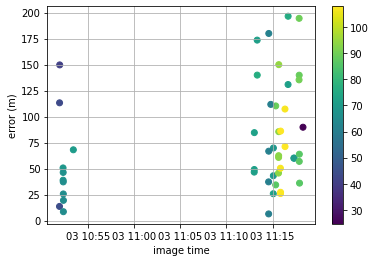

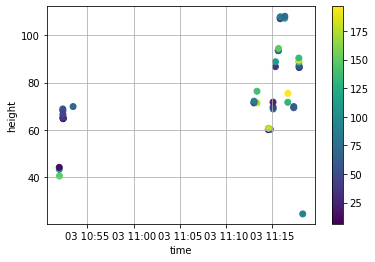

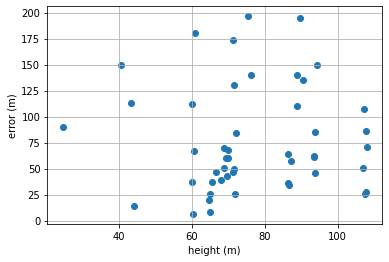

In [5]:
import matplotlib.pyplot as plt
import math
import numpy as np

print(sum(error_x)/len(error_x))
print(sum(error_y)/len(error_y))

total_error=[]
for i in range(len(error_x)):
    total_error.append(math.sqrt(error_x[i]**2+error_y[i]**2))

plt.figure(0)
plt.scatter(error_x,error_y)
plt.grid()
plt.xlabel("error in x")
plt.ylabel("error in y")

plt.figure(1)
plt.scatter(image_pitch,dist_error)
plt.grid()
plt.xlabel("pitch")
plt.ylabel("error (m)")

plt.figure(2)
plt.scatter(image_roll,dist_error)
plt.grid()
plt.xlabel("roll")
plt.ylabel("error (m)")


plt.figure(3)
plt.scatter(image_roll, image_pitch, c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

roll_pitch=[]
for i in range(len(error_x)):
    roll_pitch.append(math.sqrt(image_pitch[i]**2+image_roll[i]**2))

plt.figure(4)
plt.scatter(image_height,roll_pitch,c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("height")
plt.ylabel("roll_pitch")

plt.figure(5)
plt.scatter(image_time,dist_error,c=image_height, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("image time")
plt.ylabel("error (m)")

plt.figure(6)
plt.scatter(image_time,image_height,c=dist_error, cmap='viridis')
plt.grid()
plt.colorbar()
plt.xlabel("time")
plt.ylabel("height")

plt.figure(7)
plt.scatter(image_height, dist_error)
plt.xlabel("height (m)")
plt.ylabel("error (m)")
plt.grid()


C:\Users\olive\AppData\Local\Temp\ipykernel_16560\1156539918.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


<Figure size 432x288 with 0 Axes>

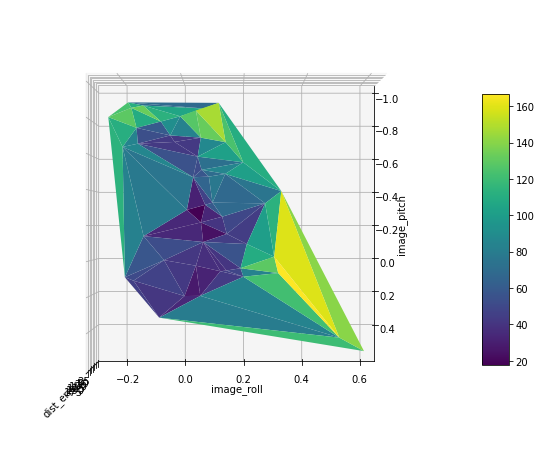

In [6]:

plt.figure(8)
import pandas as pd
import seaborn as sns
df = pd.DataFrame.from_dict(np.array([image_pitch,image_roll,dist_error]).T)
df.columns = ['x','y','z']
df['z'] = pd.to_numeric(df['z'])
pivotted= df.pivot('y','x','z')

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('image_pitch')
ax.set_ylabel('image_roll')
ax.set_zlabel('dist_error')
plt.grid()
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

surf = ax.plot_trisurf(df.x, df.y, df.z, cmap='viridis', linewidth=0.1)
ax.view_init(azim=0, elev=90)
fig.colorbar(surf, shrink=0.5, aspect=10)    
plt.show()
  

In [7]:
from ipyleaflet import (
    Map,
    Marker,
    MarkerCluster,
    TileLayer,
    ImageOverlay,
    Polyline,
    Polygon,
    Rectangle,
    Circle,
    CircleMarker,
    Popup,
    GeoJSON,
    DrawControl,
    basemaps,
    AwesomeIcon
)

from ipywidgets import HTML, Layout

center = [34.6252978589571, -77.34580993652344]
zoom = 100

m = Map(basemap=basemaps.Esri.WorldImagery, center=target_location, zoom=zoom, layout=Layout(width='800px', height='800px'))
m.add_layer(
    CircleMarker(location=target_location, radius=20)
)
m.add_layer(
    MarkerCluster(markers=[
        Marker(location=loc) for loc in locations
    ],
    disable_clustering_at_zoom=3)
)

avg = [sum(x)/len(x) for x in zip(*locations)]
icon = AwesomeIcon(marker_color="red")

m.add_layer(
    Marker(location=avg, color="red", icon=icon)
)

m

Map(center=[51.292308, -0.484431], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [ ]:
plt.figure(3)
plt.scatter(image_roll, image_pitch, c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

In [155]:
df = [{ 
    "px":row[1][0][0][0], 
    "py": row[1][0][0][1], 
    "lat": row[1][1].lat,
    "lon": row[1][1].lon,
    "alt": row[1][1].alt,
    "roll": row[1][1].roll,
    "pitch": row[1][1].pitch,
    "heading": row[1][1].heading
} for row in enumerate(all_data)]
df.append({
    "px":1920/2, 
    "py": 1080/2, 
    "lat": target_location[0],
    "lon": target_location[1],
    "alt": 100,
    "roll": 10,
    "pitch": 10,
    "heading": 350
})
df = pd.DataFrame(df)


In [166]:
import pyproj
import math
geodesic = pyproj.Geod(ellps='WGS84')
df["bearing_act"] = df.apply(lambda row: geodesic.inv(target_location[0], target_location[1], row.lat, row.lon)[0], axis=1)
df["distance_act"] = df.apply(lambda row: geodesic.inv(target_location[0], target_location[1], row.lat, row.lon)[2], axis=1)
df["anglez_act"] = df.apply(lambda row: math.degrees(math.atan(row.distance_act/row.alt)), axis=1)

RESOLUTION = np.array([1080, 1920]) # px
ASPECT_RATIO = RESOLUTION[1]/RESOLUTION[0]
SENSOR_W = 6.4 #mm
SENSOR_H = SENSOR_W / ASPECT_RATIO #mm
LENS_F = 6 #mm
FOV_X = 2 * math.atan2(SENSOR_W/2, LENS_F)
FOV_Y = 2 * math.atan2(SENSOR_H/2, LENS_F)
print(FOV_X, FOV_Y)

df["scale_x"] = df.apply(lambda row: 2*row.alt/(1920*((FOV_X)/2 + math.degrees(row.roll))), axis=1)
df["scale_y"] = df.apply(lambda row: 2*row.alt/(1080*((FOV_Y)/2 + math.degrees(row.pitch))), axis=1)
df["offset_x"] = df.apply(lambda row: row.scale_x*row.px*math.tan(row.roll), axis=1)
df["offset_y"] = df.apply(lambda row: row.scale_y*row.py*math.tan(row.pitch), axis=1)
R = lambda x: np.array([[math.cos(x), -math.sin(x)],[math.sin(x), math.cos(x)]])
df["P"] = df.apply(lambda row: R(math.radians(row.heading)).T@np.array([row.offset_x, row.offset_y]), axis=1)
df["est_lat"] = df.apply(lambda row: row.lat + row.P[0]/111320, axis=1)
df["est_lon"] = df.apply(lambda row: row.lon + row.P[1]/(40075000 * math.cos(math.radians(row.lat))) / 360, axis=1)
df["est_distance"] = df.apply(lambda row: math.sqrt(row.P[0]**2 + row.P[1]**2), axis=1)
df["distance_error"] = df.apply(lambda row: geopy.distance.distance(target_location, (row.lat,row.lon)).m, axis=1)
df


0.9799146525074567 0.5829135889557343


,px,py,lat,lon,alt,roll,pitch,heading,bearing_act,distance_act,anglez_act,scale_x,scale_y,offset_x,offset_y,P,est_lat,est_lon,est_distance,distance_error
0,475.0,1037.0,51.292454,-0.484338,68.12,-0.172233,0.129108,48.0,57.701937,19.266356,15.792476,-0.007566,0.016407,-3.540804,16.872188,"[10.169219285756412, 13.92102753822321]",51.292546,-0.484338,17.239722,17.524204
1,326.0,1060.0,51.292439,-0.484385,68.89,-0.199654,0.107176,49.0,70.624973,15.398750,12.600008,-0.006554,0.019834,-2.094114,20.903161,"[14.401953365696539, 15.29415534611591]",51.292568,-0.484385,21.007795,14.872003
2,1839.0,569.0,51.292702,-0.485065,68.90,-0.153296,-0.680518,316.0,147.974170,82.662509,50.188467,-0.008654,-0.003297,-15.728273,-1.458119,"[-10.301078600292234, -11.974659496614661]",51.292609,-0.485065,15.795717,62.242114
3,145.0,1027.0,51.292432,-0.484971,69.40,0.189444,0.052480,17.0,166.935296,61.308146,41.457465,0.006373,0.038965,0.907485,39.961464,"[12.551433386025671, 37.95001482739497]",51.292545,-0.484971,39.971766,40.140481
4,1475.0,786.0,51.292669,-0.485003,69.71,-0.161504,-0.780167,327.0,147.525957,74.905927,47.057704,-0.008286,-0.002907,-12.062822,-1.624052,"[-9.23221138982453, -7.931928102245283]",51.292586,-0.485003,12.171656,56.612328
5,125.0,758.0,51.292457,-0.484961,69.89,0.199023,0.102589,17.0,164.223781,60.840944,41.040363,0.006121,0.020979,0.750065,15.818336,"[5.342124538744631, 14.907852676136232]",51.292505,-0.484960,15.836110,40.466707
6,374.0,758.0,51.293079,-0.483501,69.90,0.065537,-0.887848,26.0,39.855954,133.972677,62.446781,0.017153,-0.002559,6.401343,-1.224258,"[5.216809668181619, -3.9065202939063965]",51.293126,-0.483501,6.517362,107.576430
7,1128.0,912.0,51.292584,-0.484536,71.43,-0.047367,-0.734388,354.0,110.697347,32.818947,24.676703,-0.033456,-0.003166,-37.696373,-2.142876,"[-37.26587632792866, -6.071481344798784]",51.292249,-0.484536,37.757230,31.544259
8,1091.0,1039.0,51.292418,-0.485005,71.44,0.502945,0.428114,258.0,169.065260,64.609567,42.125851,0.002539,0.005330,2.427263,5.038180,"[-5.432740435047564, 1.3267245647239634]",51.292369,-0.485005,5.592394,41.851434
9,1491.0,747.0,51.292644,-0.484557,71.63,0.030024,-0.485822,339.0,110.486313,39.903416,29.121168,0.033759,-0.004816,50.311542,-3.181186,"[48.10990587906579, 15.060151064514166]",51.293076,-0.484557,50.412014,38.383807


In [167]:
coords = [(lat, lon) for lat,lon in zip(df.est_lat, df.est_lon)]

from ipyleaflet import (
    Map,
    Marker,
    MarkerCluster,
    TileLayer,
    ImageOverlay,
    Polyline,
    Polygon,
    Rectangle,
    Circle,
    CircleMarker,
    Popup,
    GeoJSON,
    DrawControl,
    basemaps,
    AwesomeIcon
)

from ipywidgets import HTML, Layout

center = [34.6252978589571, -77.34580993652344]
zoom = 100

m = Map(basemap=basemaps.Esri.WorldImagery, center=target_location, zoom=zoom, layout=Layout(width='800px', height='800px'))
m.add_layer(
    CircleMarker(location=target_location, radius=20)
)
m.add_layer(
    MarkerCluster(markers=[
        Marker(location=loc) for loc in coords
    ],
    disable_clustering_at_zoom=3)
)

avg = [sum(x)/len(x) for x in zip(*coords)]
icon = AwesomeIcon(marker_color="red")

m.add_layer(
    Marker(location=avg, color="red", icon=icon)
)

m

Map(center=[51.292308, -0.484431], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Text(0, 0.5, 'heading')

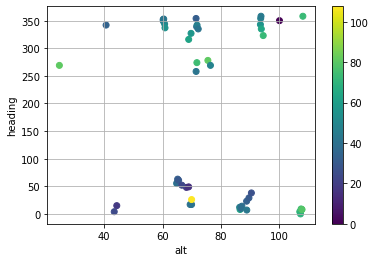

In [168]:
plt.figure(10)
plt.scatter(df.alt, df.heading, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("alt")
plt.ylabel("heading")

tried morphology, reduces noise but increases processing time by ~5%. doesn't seem to affect accuracy.
https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

tried CLACHE - no noticeable accuracy increase

tried making C more negative - reduces noise and chance of identifying target

In [4]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\10_04_22\squares"
files = [f for f in os.listdir(directory)]


options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "min_solidity": 0.6,
    "debug":True
}

results = 0
false_positives = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    result = find_targets(image, options)
    try:
        result[0]
        results+=1
    except KeyboardInterrupt:
        raise Exception()
    except Exception:
        #find_targets(image, options)
        pass

print(results/len(files))
print(results)
print(len(files))


0.7666666666666667
23
30


In [ ]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\03_04_22\square"
image_number = 23
files = [f for f in os.listdir(directory)]
image = cv2.imread(directory + "//" + files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False
}

imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display(imgGray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(imgGray)
display(cl1)
imgBlurred = cv2.GaussianBlur(cl1, (59,59),0)
# laplacian = cv2.Laplacian(cv2.bitwise_not(imgBlurred),cv2.CV_64F)
# display(laplacian)
img_thresh = cv2.adaptiveThreshold(
    imgBlurred,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY,
    399,
    -69
)
display(img_thresh)

contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
squareIndexes = filterContours(contours, options)

for index in squareIndexes:
    cv2.drawContours(image, contours[index], -1, (0, 255, 0), 3)
display(image)

In [4]:
import numpy as np

directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\03_04_22\square"
image_number = 23
files = [f for f in os.listdir(directory)]
image = cv2.imread(directory + "//" + files[image_number])

src = image
width  = src.shape[1]
height = src.shape[0]

# https://stackoverflow.com/questions/26602981/correct-barrel-distortion-in-opencv-manually-without-chessboard-image

distCoeff = np.zeros((4,1),np.float64)

distCoeff[0,0] = -0.7e-5 # k1
distCoeff[1,0] = 0 # k2
distCoeff[2,0] = 0 # p1
distCoeff[3,0] = 0.0 # p2

# assume unit matrix for camera
cam = np.eye(3,dtype=np.float32)

cam[0,2] = width/2.0  # define center x 
cam[1,2] = height/2.0 # define center y
cam[0,0] = 10        # define focal length x
cam[1,1] = 6        # define focal length y


image = cv2.imread(directory + "//" + files[3])

dst = cv2.undistort(image,cam,distCoeff)

numpy_vertical = np.vstack((image, dst))

width  = dst.shape[1]
height = dst.shape[0]
print(width, height)

display(numpy_vertical)

1920 1080
